# Predict overall rating for a beer

In this notebook, using the ratings for four attributes of the beers (aroma, appearance, palate and taste), we train a regression model to predict the overall rating for a beer.

We develop a regression model to identify the correlation between the attributes (collectively as well as individually) and the overall rating for a beer

## Imports

In [ ]:
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [1]:
from google.colab import files 


uploaded = files.upload()

import io

Saving train.csv to train.csv


In [3]:
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['train.csv'])) 
df.drop(['review/timeStruct','user/ageInSeconds','user/birthdayRaw','user/birthdayUnix','user/gender','index','user/profileName'], axis = 1,inplace = True)

df.columns = ['beer_abv','beer_beerid','brewery_id','beer_name','beer_style','review_appearance','review_aroma','review_overall','review_palate','review_taste','review_text','review_time']
df = df.dropna()
df.head()

,beer_abv,beer_beerid,brewery_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_taste,review_text,review_time
0,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,1229398690
1,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,1218238738
2,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,1101492422
3,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,1308532025
4,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,1299912708


### Create a New DataFrame 
- Merge the reviews (Database style joining - OUTERJOIN)

The total number of samples are greater than any one DataFrame. For example, all the beers that have overall rating might not have the corresponding aroma rating. 

Hence, concatenating and making a new DataFrame has many more samples than any one of the reviews and it has holes in the data.

In [ ]:
# New DataFrame - reviews
data_copy - dict()
reviews = data_copy['review_overall']

for review in ['review_aroma', 'review_appearance', 'review_palate', 'review_taste']:
    reviews = pd.merge(reviews, data_copy[review], how='outer')


## Data Cleaning

- Remove NaNs
- Other option is to impute the data to fill holes by looking at rating for similar beer styles.

In [ ]:
reviews = reviews.dropna()
reviews.head()

,beer_beerid,beer_name,beer_style,review_overall,review_aroma,review_appearance,review_palate,review_taste
0,436,Amstel Light,Light Lager,3.0,2.0,3.0,2.5,2.5
1,25414,Caldera Pale Ale,American Pale Ale (APA),4.0,3.5,3.5,4.0,4.0
2,57110,D.O.R.I.S. The Destroyer Double Imperial Stout,Russian Imperial Stout,4.5,4.5,4.5,5.0,5.0
3,1959,Farmhouse Summer Ale,American Blonde Ale,4.0,3.5,4.0,4.0,4.0
4,9689,White Rascal,Witbier,5.0,4.0,4.0,3.5,4.5


## Visualize Data

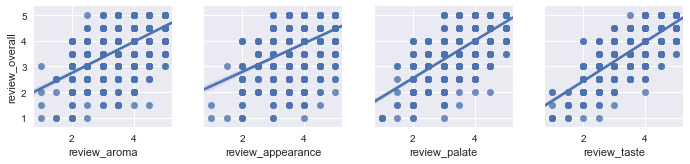

In [ ]:
sns.pairplot(reviews, x_vars=['review_aroma', 'review_appearance', 'review_palate', 'review_taste'], 
             y_vars=['review_overall'], kind='reg')

## Regression Models

- Isolate features (X) and targets(y). 
- Features are the attributes of the beers (aroma, appearance, palate and taste) and targets are overall reviews
- Split dats into KFolds (Bootstrapping/Cross-validation)
- Make an ML pipeline - Standardize data and fit a model
- Apply different regressors to compare the fits


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

X = reviews[['review_aroma', 'review_appearance','review_palate', 'review_taste']]
y = reviews['review_overall']

### Instantiate multiple regression models
- Linear Regression
- Lasso ( with L1 penalty)
- Ridge (with L2 penalty)
- KNeighbors

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
#linear = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
#lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01, fit_intercept=True))
#ridge = make_pipeline(StandardScaler(), Ridge(fit_intercept=True))
#kneighbors = make_pipeline(StandardScaler(), KNeighborsRegressor())

### Generate KFolds

In [ ]:
data_sets = dict()
for split in range(10):
    _d = dict()
    for train_idx, test_idx in kfold.split(X):
        _d.update({
                'X_train' : X.iloc[train_idx],
                'X_test': X.iloc[test_idx],
                'y_train': y.iloc[train_idx],
                'y_test': y.iloc[test_idx]
            })
    data_sets.update({
            split : _d
        })

### Define Regression class 
- To wrap scikit-learn methods

In [ ]:
from sklearn import metrics

class Regression:
    def __init__(self, regressor):
        self.regressor = regressor
        
    def fit(self, X, y):
        self.regressor.fit(X, y) 

    def predict(self, X, y):
        return self.regressor.predict(X)
    
    def score(self, X, y):
        return self.regressor.score(X, y)

    def mean_squared_error(self, X, y):
        return metrics.mean_squared_error(self.predict(X,y), y)
    
    def accuracy(self, X,y):
        return metrics.r2_score(self.predict(X,y), y)

### Define some utility functions
- model_fit: Fits a regression model using one of the pipelines defined above
- averaged_params: Fit a linear model for each data set generated by KFold splits
- compute_averages: Compute averages of coefficeints, error and score over KFolds

In [ ]:
def model_fit(data_set, regressor):
    params = dict()
    regressor.fit(data_set['X_train'], data_set['y_train'])
    neighbors = True if 'neighbors' in regressor.regressor.steps[1][0] else False
    params.update({
            'coeffs' : [0.0] if neighbors else regressor.regressor.steps[1][1].coef_,
            'intercept': [0.0] if neighbors else regressor.regressor.steps[1][1].intercept_,
            'mean_sq_error': regressor.mean_squared_error(data_set['X_train'], data_set['y_train']),
            'accuracy': regressor.accuracy(data_set['X_test'], data_set['y_test'])
        })
    #print (params)
    return params
    
def compute_averages(list_of_dicts):
    averaged_params = dict()
    for set_key in list_of_dicts[0].keys():
        _list = [val for obj in list_of_dicts for key, val in obj.items() if key == set_key]
        if isinstance(_list[0], dict):
            averaged_params[set_key] = compute_averages(_list)
        elif isinstance(_list[0], list) or isinstance(_list[0], np.ndarray):
            if isinstance(_list[0][0], dict):
                sub_list = [[_list[i][j] for i in range(len(_list))] for j in range(len(_list[0]))]
                averaged_params[set_key] = [compute_averages(x) for x in sub_list]
            else:
                averaged_params[set_key] = np.round(np.average(np.array(_list), axis=0), 3)
        elif isinstance(_list[0], float) or isinstance(_list[0], int):
            averaged_params[set_key] = np.round(np.average(np.array(_list)), 3)
        else:
            pass
    return averaged_params

def averaged_params(regressor):
    multiple_params = list()
    for set_key, value in data_sets.items():
        multiple_params.append({
                set_key: model_fit(value, regressor)
            })
    return compute_averages(multiple_params)

### Linear Regression

In [ ]:
# Linear Regression Pipeline
linear = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
regressor = Regression(linear)

# Averaged Model Parameters over 5 splits (or 5-fold cross-validation) 
averaged_params(regressor)

{0: {'accuracy': 0.501,
  'coeffs': array([ 0.04 ,  0.014,  0.161,  0.356]),
  'intercept': 3.823,
  'mean_sq_error': 0.151}}

### Lasso (Regularization - L1 Penalty)

In [ ]:
# Lasso Regression Pipeline
for alpha in [1.0, 0.1, 0.01, 0.001]:
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=alpha, fit_intercept=True))
    regressor = Regression(lasso)
    print ("Lasso: alpha = ", alpha)
    print (averaged_params(regressor))
    print ('**********************')

Lasso: alpha =  1.0
{0: {'coeffs': array([ 0.,  0.,  0.,  0.]), 'intercept': 3.823, 'accuracy': -2.6980869800436656e+29, 'mean_sq_error': 0.42199999999999999}}
**********************
Lasso: alpha =  0.1
{0: {'coeffs': array([ 0.   ,  0.   ,  0.116,  0.322]), 'intercept': 3.823, 'accuracy': 0.071999999999999995, 'mean_sq_error': 0.16400000000000001}}
**********************
Lasso: alpha =  0.01
{0: {'coeffs': array([ 0.036,  0.009,  0.158,  0.354]), 'intercept': 3.823, 'accuracy': 0.47199999999999998, 'mean_sq_error': 0.151}}
**********************
Lasso: alpha =  0.001
{0: {'coeffs': array([ 0.04 ,  0.014,  0.161,  0.356]), 'intercept': 3.823, 'accuracy': 0.498, 'mean_sq_error': 0.151}}
**********************


### Ridge (Regularization - L2 Penalty)

In [ ]:
# Ridge Regression Pipeline
for alpha in [1.0, 0.1, 0.01, 0.001]:
    ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha, fit_intercept=True))
    regressor = Regression(ridge)
    print ("Ridge: alpha = ", alpha)
    print (averaged_params(regressor))
    print ('**********************')

Ridge: alpha =  1.0
{0: {'coeffs': array([ 0.04 ,  0.014,  0.161,  0.356]), 'intercept': 3.823, 'accuracy': 0.501, 'mean_sq_error': 0.151}}
**********************
Ridge: alpha =  0.1
{0: {'coeffs': array([ 0.04 ,  0.014,  0.161,  0.356]), 'intercept': 3.823, 'accuracy': 0.501, 'mean_sq_error': 0.151}}
**********************
Ridge: alpha =  0.01
{0: {'coeffs': array([ 0.04 ,  0.014,  0.161,  0.356]), 'intercept': 3.823, 'accuracy': 0.501, 'mean_sq_error': 0.151}}
**********************
Ridge: alpha =  0.001
{0: {'coeffs': array([ 0.04 ,  0.014,  0.161,  0.356]), 'intercept': 3.823, 'accuracy': 0.501, 'mean_sq_error': 0.151}}
**********************


### KNeighbors

In [ ]:
# KNeighbors Regression Pipeline
for neighbors in range(1,10):
    kneighbors = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=neighbors))
    regressor = Regression(kneighbors)
    print ("KNeighbors: neighbors = ", neighbors)
    print (averaged_params(regressor))
    print ('**********************')
    

KNeighbors: neighbors =  1
{0: {'coeffs': array([ 0.]), 'intercept': array([ 0.]), 'accuracy': 0.34699999999999998, 'mean_sq_error': 0.32600000000000001}}
**********************
KNeighbors: neighbors =  2
{0: {'coeffs': array([ 0.]), 'intercept': array([ 0.]), 'accuracy': 0.27700000000000002, 'mean_sq_error': 0.17799999999999999}}
**********************
KNeighbors: neighbors =  3
{0: {'coeffs': array([ 0.]), 'intercept': array([ 0.]), 'accuracy': 0.312, 'mean_sq_error': 0.16300000000000001}}
**********************
KNeighbors: neighbors =  4
{0: {'coeffs': array([ 0.]), 'intercept': array([ 0.]), 'accuracy': 0.29599999999999999, 'mean_sq_error': 0.152}}
**********************
KNeighbors: neighbors =  5
{0: {'coeffs': array([ 0.]), 'intercept': array([ 0.]), 'accuracy': 0.29299999999999998, 'mean_sq_error': 0.151}}
**********************
KNeighbors: neighbors =  6
{0: {'coeffs': array([ 0.]), 'intercept': array([ 0.]), 'accuracy': 0.315, 'mean_sq_error': 0.14599999999999999}}
***********